In [1]:
"""C 2023 Matthew C. Digman
code example to run the galactic binary parameter estimation pipeline
and plot results"""

from time import perf_counter

import numpy as np

import likelihood_gb as trial_likelihood

from DTMCMC.ptmcmc_helpers import PTMCMCChain
from DTMCMC.temperature_ladder_helpers import TemperatureLadder
from DTMCMC.corr_summary_helpers import CorrelationSummary
from DTMCMC.proposal_strategy_helpers import ProposalStrategyParameters
from DTMCMC.proposal_manager_helper import get_default_proposal_manager

from instrument_noise import get_galactic_novar_noise_model

using mkl fft
Filter length (seconds) 9.855000e+05
dt=30.0750732421875s Tobs=4.0
full filter bandwidth 1.217656e-05  samples 12
coeffs/WDMcoeffs_Nsf=150_mult=8_Nfd=10_Nf=2048_Nt=2048_dt=30.0750732421875_dfdot=0.1_Nfd_neg5_fast.h5
cache checked and missed
norm=71690.78694082187
6.159375e+04 8.11770674784373e-06 8.11770674784373e-06 -3.294858e-12 3.294858e-12
loop start time  0.07880187034606934 s


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


got full evcs in 5.006519 s


In [2]:
# starting variables
n_chain = 8                        # number of total chains for parallel tempering
n_cold = 2                         # number of T=1 chains for parallel tempering
n_burnin = 10000                   # number of iterations to discard as burn in
block_size = 1000                  # number of iterations per block when advancing the chain state
store_size = 20000                 # number of samples to store total
N_blocks = store_size//block_size  # number of blocks the sampler must iterate through

de_size = 5000                     # number of samples to store in the differential evolution buffer
T_max = 1000.                      # maximum temperature for geometric part of temperature ladder

sigma_prior_lim = 20.              # minimum standard deviations to allow around prior in amplitude, frequency, and frequency derivative

params_true = np.array([1.e-22, -0.26,  4.6,  3.e-3, 2.5e-17, 0.25,  1.5,  1.6])  # true parameters for search

# note that too many chains starting from the fiducial parameters can make the chain converge slower, if it fails to find secondary modes
n_true_start = 4                   # how many chains to start at params_true (0 for a blind search; the rest will start from prior draws)

In [3]:
# create needed objects

noise_AET_dense = get_galactic_novar_noise_model()                 # get the noise model for the galactic background best fit with no time variability
strategy_params = ProposalStrategyParameters(de_size=de_size)      # get the object which stores various parameters related to the overall search strategy
T_ladder = TemperatureLadder(n_chain, n_cold=n_cold, T_max=T_max)  # get the temperature ladder object

like_obj = trial_likelihood.get_noiseless_gb_likelihood(params_true.copy(), noise_AET_dense, sigma_prior_lim, strategy_params)  # get the likelihood object
params_true = like_obj.correct_bounds(params_true)                 # make sure the conventions on the parameters match

# create the starting samples
starting_samples = np.zeros((T_ladder.n_chain,like_obj.n_par))
for itrt in range(0,n_chain):
    if itrt<n_true_start:
        # use the true value
        starting_samples[itrt] = params_true
    else:
        # use a prior draw
        starting_samples[itrt] = like_obj.prior_draw()


#create the overarching proposal manager object
proposal_manager = get_default_proposal_manager(T_ladder, like_obj, strategy_params, starting_samples)

print('Chain parameters', n_cold, n_chain, n_burnin, block_size, store_size, de_size, T_max)
print('True Template SNR: ', like_obj.get_snr(params_true))

nrm instrument 10988.754949564865
getting gb likelihood
[110 120 121 210 211 220 221 300]
Chain parameters 2 8 10000 1000 20000 5000 1000.0
True Template SNR:  52.695960208428666


In [4]:
# create the chain object
mcc = PTMCMCChain(T_ladder, like_obj, strategy_params, block_size, store_size, starting_samples=starting_samples)


[110 120 121 210 211 220 221 300]


In [5]:
# the main loop which actually advances the MCMC state
mcc.advance_N_blocks(N_blocks)

fisher update 0
fisher update 1000
fisher update 2000
fisher update 3000
fisher update 4000
fisher update 5000
fisher update 6000
fisher update 7000
fisher update 8000
fisher update 9000
fisher update 10000
fisher update 11000
fisher update 12000
fisher update 13000
fisher update 14000
fisher update 15000
fisher update 16000
fisher update 17000
fisher update 18000
fisher update 19000
Acceptance Summary:
 Temperature  std full        std subspace    DE scale full   DE big full     prior full     
1.000000e+00  0.2189958       No Trials       0.3944927       0.0675155      <1.499e-04      
3.981072e+00  No Trials       0.2132616       0.3974122       0.0725420      <2.975e-04      
1.584893e+01  No Trials       0.2286659       0.4043584       0.0756757      <2.981e-04      
6.309573e+01  No Trials       0.2562352       0.3931523       0.0820265       0.0003049      
2.511886e+02  No Trials       0.4299576       0.5567901       0.3292469       0.1047789      
1.000000e+03  No Trials      

In [6]:
# generate some summary information
corr_sum = CorrelationSummary()
corr_sum.summarize_blocks(mcc, n_burnin)
corr_sum.final_prints(mcc, n_burnin)

# get flattened samples for plotting
samples_flattened, logLs_flattened = mcc.get_stored_flattened(corr_sum.restrict_n_burnin(mcc, n_burnin))

last two Ts 1000.0 inf
logL burns [0]
0
2 8
correlation efficiencies +7.35876e-03 +1.88864e-02 +1.04093e-02 +5.19526e-03 +6.22738e-03 +1.23952e-02 +3.70162e-03 +4.40671e-03
empirical   efficiencies +3.20953e-03 +1.67799e-02 +1.17114e-02 +2.67164e-03 +2.29489e-03 +6.09962e-03 +3.23590e-03 +6.63028e-03
mean correlation efficiency 8.57258e-03
mean empirical   efficiency 6.57914e-03
overall effective sample sizes: [128.39406929 671.26131759 468.50313186 106.87634279  91.80474826
 244.00918044 129.44902466 265.23759616]
best estimate of autocorrelation lengths:  6.53636384e+01 3.78675543e+01 4.39469976e+01 1.22226421e+02 1.06467670e+02 4.54892658e+01 1.44683180e+02 9.65131009e+01


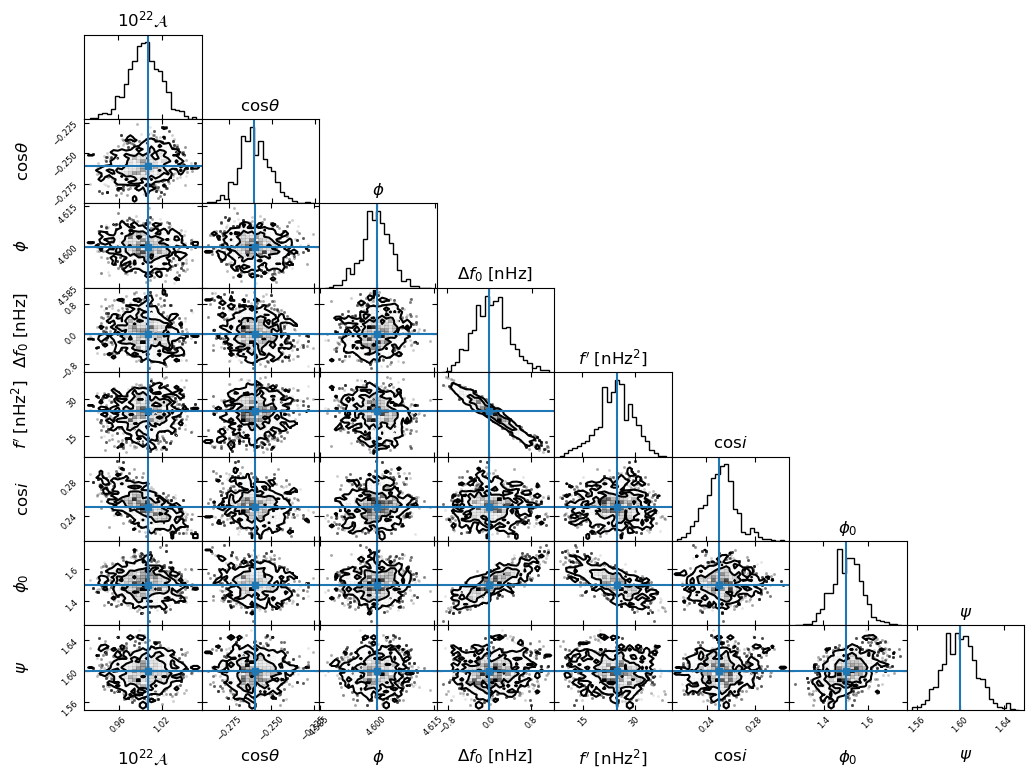

In [7]:
# generate a corner plot
import matplotlib.pyplot as plt 
import corner

# reformat the samples to make the plots look nicer
samples_format, params_true_format, labels = trial_likelihood.format_samples_output(samples_flattened, params_true)

# create the corner plot figure
fig = plt.figure(figsize=(10, 7.5))
figure = corner.corner(samples_format, fig=fig, bins=25, hist_kwargs={"density": True}, show_titles=True, title_fmt=None,
                       title_kwargs={"fontsize": 12}, labels=labels, max_n_ticks=3, label_kwargs={"fontsize": 12}, labelpad=0.15,
                       smooth=0.25, levels=[0.682, 0.954])

# overplot the true parameters
corner.overplot_points(figure, params_true_format[None], marker="s", color='tab:blue', markersize=4)
corner.overplot_lines(figure, params_true_format, color='tab:blue')

# adjust the figure to fit the box better
fig.subplots_adjust(wspace=0., hspace=0., left=0.05, top=0.95, right=0.99, bottom=0.05)
for ax in figure.get_axes():
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, labelsize=6)
plt.show()